<h1>요구 사항과 숙제 후기는 가장 아래에 있습니다.</h>

In [10]:
import os

import numpy as np
import pandas as pd
import torch
from torch import nn, optim
from torch.utils.data import Dataset, random_split, DataLoader
from datetime import datetime
import wandb
import argparse

In [11]:
# 출력 폭 제한을 해제 (무제한)
pd.set_option("display.width", None)
# 모든 컬럼 출력되도록 설정
pd.set_option("display.max_columns", None)

class TitanicDataset(Dataset):
  def __init__(self, X, y):
    print(type(X))           # np.ndarray여야 함
    print(X.dtype)
    print(type(y))           # np.ndarray여야 함
    print(y.dtype)
    self.X = torch.FloatTensor(X.astype(np.float32))
    self.y = torch.LongTensor(y)

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    feature = self.X[idx]
    target = self.y[idx]
    return {'input': feature, 'target': target}

  def __str__(self):
    str = "Data Size: {0}, Input Shape: {1}, Target Shape: {2}".format(
      len(self.X), self.X.shape, self.y.shape
    )
    return str


class TitanicTestDataset(Dataset):
  def __init__(self, X):
    self.X = torch.FloatTensor(X.astype(np.float32))

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    feature = self.X[idx]
    return {'input': feature}

  def __str__(self):
    str = "Data Size: {0}, Input Shape: {1}".format(
      len(self.X), self.X.shape
    )
    return str


def get_preprocessed_dataset():
    CURRENT_FILE_PATH = os.path.join("..","..","_03_homeworks","homework_2")

    train_data_path = os.path.join(CURRENT_FILE_PATH, "train.csv")
    test_data_path = os.path.join(CURRENT_FILE_PATH, "test.csv")

    train_df = pd.read_csv(train_data_path)
    test_df = pd.read_csv(test_data_path)

    all_df = pd.concat([train_df, test_df], sort=False)

    all_df = get_preprocessed_dataset_1(all_df)

    all_df = get_preprocessed_dataset_2(all_df)

    all_df = get_preprocessed_dataset_3(all_df)

    all_df = get_preprocessed_dataset_4(all_df)

    all_df = get_preprocessed_dataset_5(all_df)

    all_df = get_preprocessed_dataset_6(all_df)

    print(all_df.columns)
    print(all_df.head(10))

    train_X = all_df[~all_df["Survived"].isnull()].drop("Survived", axis=1).reset_index(drop=True)
    train_y = train_df["Survived"]

    test_X = all_df[all_df["Survived"].isnull()].drop("Survived", axis=1).reset_index(drop=True)

    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()

    dataset = TitanicDataset(scaler.fit_transform(train_X), train_y.values)
    print(dataset)

    train_dataset, validation_dataset = random_split(dataset, [0.8, 0.2])
    test_dataset = TitanicTestDataset(scaler.transform(test_X))
    print(test_dataset)

    return train_dataset, validation_dataset, test_dataset


def get_preprocessed_dataset_1(all_df):
    # Pclass별 Fare (요금) 평균값을 사용하여 Fare 결측치 메우기
    Fare_mean = all_df[["Pclass", "Fare"]].groupby("Pclass").mean().reset_index()
    Fare_mean.columns = ["Pclass", "Fare_mean"]
    all_df = pd.merge(all_df, Fare_mean, on="Pclass", how="left")
    all_df.loc[(all_df["Fare"].isnull()), "Fare"] = all_df["Fare_mean"]
    all_df = all_df.drop(columns=["Fare_mean"])

    return all_df


def get_preprocessed_dataset_2(all_df):
    # name을 세 개의 컬럼으로 분리하여 다시 all_df에 합침
    name_df = all_df["Name"].str.split("[,.]", n=2, expand=True)
    name_df.columns = ["family_name", "title", "name"]
    name_df["family_name"] = name_df["family_name"].str.strip()
    name_df["title"] = name_df["title"].str.strip()
    name_df["name"] = name_df["name"].str.strip()
    all_df = pd.concat([all_df, name_df], axis=1)

    return all_df


def get_preprocessed_dataset_3(all_df):
    # title별 Age 평균값을 사용하여 Age 결측치 메우기
    title_age_mean = all_df[["title", "Age"]].groupby("title").median().round().reset_index()
    title_age_mean.columns = ["title", "title_age_mean", ]
    all_df = pd.merge(all_df, title_age_mean, on="title", how="left")
    all_df.loc[(all_df["Age"].isnull()), "Age"] = all_df["title_age_mean"]
    all_df = all_df.drop(["title_age_mean"], axis=1)

    return all_df


def get_preprocessed_dataset_4(all_df):
    # 가족수(family_num) 컬럼 새롭게 추가
    all_df["family_num"] = all_df["Parch"] + all_df["SibSp"]

    # 혼자탑승(alone) 컬럼 새롭게 추가
    all_df.loc[all_df["family_num"] == 0, "alone"] = 1
    all_df["alone"] = all_df["alone"].fillna(0)

    # 학습에 불필요한 컬럼 제거
    all_df = all_df.drop(["PassengerId", "Name", "family_name", "name", "Ticket", "Cabin"], axis=1)

    return all_df


def get_preprocessed_dataset_5(all_df):
    # title 값 개수 줄이기
    all_df.loc[
    ~(
            (all_df["title"] == "Mr") |
            (all_df["title"] == "Miss") |
            (all_df["title"] == "Mrs") |
            (all_df["title"] == "Master")
    ),
    "title"
    ] = "other"
    all_df["Embarked"].fillna("missing", inplace=True)
    all_df["Sex"].fillna(all_df["Sex"].mode()[0], inplace=True)
    all_df['Sex'] = all_df['Sex'].str.strip().str.lower()
    all_df["Sex"] = all_df["Sex"].map({"male": 1, "female": 0})
    all_df = pd.get_dummies(all_df, columns=["Embarked", "title"], drop_first=True)

    return all_df


def get_preprocessed_dataset_6(all_df):
    # 카테고리 변수를 LabelEncoder를 사용하여 수치값으로 변경하기
    category_features = all_df.columns[all_df.dtypes == "object"]
    from sklearn.preprocessing import LabelEncoder
    for category_feature in category_features:
        le = LabelEncoder()
        if all_df[category_feature].dtypes == "object":
          le = le.fit(all_df[category_feature])
          all_df[category_feature] = le.transform(all_df[category_feature])

    return all_df


if __name__ == "__main__":
  train_dataset, validation_dataset, test_dataset = get_preprocessed_dataset()

  print("train_dataset: {0}, validation_dataset.shape: {1}, test_dataset: {2}".format(
    len(train_dataset), len(validation_dataset), len(test_dataset)
  ))
  print("#" * 50, 1)

  train_data_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
  validation_data_loader = DataLoader(dataset=validation_dataset, batch_size=len(validation_dataset), shuffle=True)
  test_data_loader = DataLoader(dataset=test_dataset, batch_size=len(test_dataset))

  print("[TRAIN]")
  for idx, batch in enumerate(train_data_loader):
    print("{0} - {1}: {2}".format(idx, batch['input'].shape, batch['target'].shape))

  print("[VALIDATION]")
  for idx, batch in enumerate(validation_data_loader):
    print("{0} - {1}: {2}".format(idx, batch['input'].shape, batch['target'].shape))

  print("[TEST]")
  for idx, batch in enumerate(test_data_loader):
    print("{0} - {1}".format(idx, batch['input'].shape))

C:\Users\82102\AppData\Local\Temp\ipykernel_25440\1031792946.py:151: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  all_df["Embarked"].fillna("missing", inplace=True)
C:\Users\82102\AppData\Local\Temp\ipykernel_25440\1031792946.py:152: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

F

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'family_num', 'alone', 'Embarked_Q', 'Embarked_S', 'Embarked_missing',
       'title_Miss', 'title_Mr', 'title_Mrs', 'title_other'],
      dtype='object')
   Survived  Pclass  Sex   Age  SibSp  Parch     Fare  family_num  alone  \
0       0.0       3    1  22.0      1      0   7.2500           1    0.0   
1       1.0       1    0  38.0      1      0  71.2833           1    0.0   
2       1.0       3    0  26.0      0      0   7.9250           0    1.0   
3       1.0       1    0  35.0      1      0  53.1000           1    0.0   
4       0.0       3    1  35.0      0      0   8.0500           0    1.0   
5       0.0       3    1  29.0      0      0   8.4583           0    1.0   
6       0.0       1    1  54.0      0      0  51.8625           0    1.0   
7       0.0       3    1   2.0      3      1  21.0750           4    0.0   
8       1.0       3    0  27.0      0      2  11.1333           2    0.0   
9       1

In [12]:
from pathlib import Path
BASE_PATH = Path.cwd() # BASE_PATH: /Users/yhhan/git/link_dl
print("BASE_PATH:", BASE_PATH)

import sys
sys.path.append(BASE_PATH)

from _01_code._03_real_world_data_to_tensors.m_california_housing_dataset_dataloader \
  import CaliforniaHousingDataset


def get_data():
  titanic_dataset, validation_dataset, test_dataset = get_preprocessed_dataset()
  print(titanic_dataset)
  print(len(titanic_dataset), len(validation_dataset))

  train_data_loader = DataLoader(dataset=train_dataset, batch_size=wandb.config.batch_size, shuffle=True)
  validation_data_loader = DataLoader(dataset=validation_dataset, batch_size=len(validation_dataset))
  test_data_loader = DataLoader(dataset=test_dataset, batch_size=len(test_dataset))

  return train_data_loader, validation_data_loader, test_data_loader


class MyModel(nn.Module):
  def __init__(self, n_input, n_output):
    super().__init__()

    self.model = nn.Sequential(
      nn.Linear(n_input, wandb.config.n_hidden_unit_list[0]),
      nn.LeakyReLU(),
      nn.Linear(wandb.config.n_hidden_unit_list[0], wandb.config.n_hidden_unit_list[1]),
      nn.LeakyReLU(),
      nn.Linear(wandb.config.n_hidden_unit_list[0], wandb.config.n_hidden_unit_list[1]),
      nn.LeakyReLU(),
      nn.Linear(wandb.config.n_hidden_unit_list[1], n_output),
      nn.Sigmoid()
    )

  def forward(self, x):
    #print("Type of x:", type(x))
    #print("Shape of x:", x.shape if isinstance(x, torch.Tensor) else "Not a tensor")
    x = self.model(x)
    return x


def get_model_and_optimizer():
  my_model = MyModel(n_input=15, n_output=1)
  optimizer = optim.SGD(my_model.parameters(), lr=wandb.config.learning_rate)

  return my_model, optimizer


def training_loop(model, optimizer, train_data_loader, validation_data_loader):
  n_epochs = wandb.config.epochs
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  loss_fn = nn.BCELoss()  # Use a built-in loss function
  next_print_epoch = 100
  best_val_loss = float('inf')
  counter = 0
  patience = 200

  for epoch in range(1, n_epochs + 1):
    loss_train = 0.0
    num_trains = 0
    for train_batch in train_data_loader:
      input = train_batch['input']
      target = train_batch['target'].float()
      # for i, row in enumerate(input):
        # print(f"Row {i}: {row}")

      if target.ndim == 1:
        target = target.unsqueeze(-1)
      output_train = model(input)
      loss = loss_fn(output_train, target)
      loss_train += loss.item()
      num_trains += 1

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    loss_validation = 0.0
    num_validations = 0
    with torch.no_grad():
      for validation_batch in validation_data_loader:
        input = validation_batch['input']
        target = validation_batch['target'].float()
        if target.ndim == 1:
            target = target.unsqueeze(-1)
        output_validation = model(input)
        loss = loss_fn(output_validation, target)
        loss_validation += loss.item()
        num_validations += 1

    avg_val_loss = loss_validation / num_validations
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), "best_model.pt")
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping!")
            break

    wandb.log({
      "Epoch": epoch,
      "Training loss": loss_train / num_trains,
      "Validation loss": loss_validation / num_validations
    })

    if epoch >= next_print_epoch:
      print(
        f"Epoch {epoch}, "
        f"Training loss {loss_train / num_trains:.4f}, "
        f"Validation loss {loss_validation / num_validations:.4f}"
      )
      next_print_epoch += 100

def main(args):
  current_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

  config = {
    'epochs': args.epochs,
    'batch_size': args.batch_size,
    'learning_rate': 1e-3,
    'n_hidden_unit_list': [32, 32],
    #'n_hidden_units': args.n_hidden_units,
  }
  wandb.login()

  run=wandb.init(
    mode="online" if args.wandb else "disabled",
    project="my_model_training",
    notes="My first wandb experiment",
    tags=["my_model", "california_housing"],
    name=current_time_str,
    config=config,
    reinit=True
  )
  print("Run URL:", run.get_url())
  print(args)
  print(wandb.config)

  train_data_loader, validation_data_loader, test_data_loader = get_data()

  linear_model, optimizer = get_model_and_optimizer()

  print("#" * 50, 1)

  training_loop(
    model=linear_model,
    optimizer=optimizer,
    train_data_loader=train_data_loader,
    validation_data_loader=validation_data_loader
  )
  print("training end")
  print("#" * 50, 1)
  print("test start")
  model = MyModel(n_input=15, n_output=1)
  model.load_state_dict(torch.load("best_model.pt"))
  model.eval()
  all_preds = []

  with torch.no_grad():
    for batch in test_data_loader:
      x = batch["input"].to("cpu")
      output = model(x)
      print(output[:10])
      pred = (output > 0.5).int().squeeze()
      all_preds.extend(pred.cpu().numpy())

  CURRENT_FILE_PATH = os.path.join("..","..","_03_homeworks","homework_2")
  test_data_path = os.path.join(CURRENT_FILE_PATH, "test.csv")
  submission = pd.read_csv(test_data_path)
  submission["Survived"] = np.array(all_preds).astype(int)
  submission = submission[["PassengerId", "Survived"]]
  submission.to_csv("submission.csv", index=False)
  print("test end")

  wandb.finish()


# https://docs.wandb.ai/guides/track/config
if __name__ == "__main__":
  parser = argparse.ArgumentParser()

  parser.add_argument(
    "--wandb", action=argparse.BooleanOptionalAction, default=True, help="True or False"
  )

  parser.add_argument(
    "-b", "--batch_size", type=int, default=16, help="Batch size (int, default: 512)"
  )

  parser.add_argument(
    "-e", "--epochs", type=int, default=1_000, help="Number of training epochs (int, default:1_000)"
  )

  args = parser.parse_args(args=[])

  main(args)

BASE_PATH: C:\Users\82102\git\link_dl\_04_your_code\hw1_3


Run URL: https://wandb.ai/kimminsuk9790-korea-university-of-technology-and-education/my_model_training/runs/huy72mjw
Namespace(wandb=True, batch_size=16, epochs=1000)
{'epochs': 1000, 'batch_size': 16, 'learning_rate': 0.001, 'n_hidden_unit_list': [32, 32]}


C:\Users\82102\AppData\Local\Temp\ipykernel_25440\1031792946.py:151: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  all_df["Embarked"].fillna("missing", inplace=True)
C:\Users\82102\AppData\Local\Temp\ipykernel_25440\1031792946.py:152: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

F

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'family_num', 'alone', 'Embarked_Q', 'Embarked_S', 'Embarked_missing',
       'title_Miss', 'title_Mr', 'title_Mrs', 'title_other'],
      dtype='object')
   Survived  Pclass  Sex   Age  SibSp  Parch     Fare  family_num  alone  \
0       0.0       3    1  22.0      1      0   7.2500           1    0.0   
1       1.0       1    0  38.0      1      0  71.2833           1    0.0   
2       1.0       3    0  26.0      0      0   7.9250           0    1.0   
3       1.0       1    0  35.0      1      0  53.1000           1    0.0   
4       0.0       3    1  35.0      0      0   8.0500           0    1.0   
5       0.0       3    1  29.0      0      0   8.4583           0    1.0   
6       0.0       1    1  54.0      0      0  51.8625           0    1.0   
7       0.0       3    1   2.0      3      1  21.0750           4    0.0   
8       1.0       3    0  27.0      0      2  11.1333           2    0.0   
9       1

Epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇████
Training loss,██▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▂▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁
Validation loss,█▆▄▄▃▄▃▄▄▃▃▄▄▂▂▂▃▂▃▂▁▃▂▃▁▁▁▂▂▁▄▂▂▂▃▂▂▂▂▃
Epoch,787
Training loss,0.16421
Validation loss,0.24778


# <h1>요구사항 1</h1>
기본 훈련 과정 데이터 Wandb URL
https://wandb.ai/kimminsuk9790-korea-university-of-technology-and-education/my_model_training/runs/bo9briwf?nw=nwuserkimminsuk9790

# <h1>요구사항 2</h1>
각각의 activation function을 호출한 모델을4회씩 훈련한 결과 제일 나은 성능을 보인 function은 LeakyReLU()였습니다. sigmoid()이 호출되면 validation loss가 0.3까지 안정적으로 감소하지만 천천히 감소되어서 학습 속도가 느립니다. ReLU(), ELU()가 호출되면 validation loss가 빠르게 감소하다 다시 증가합니다. 두 function은 sigmoid()를 호출 한 것보다 최소 validation loss가 작습니다. LeakyReLU()가 호출되면 빠르지도 느리지도 않게 감소하다 다시 증가하고 최소 validation loss 중 가장 작은 값을 가집니다. 각각의 activation function의 최소 validation loss를 크기 순서대로 나열하면 sigmoid()가 가장 컸고, 다음으로 ERU(), ReLU(), 마지막으로 LeakyReLU()가 가장 작았습니다.<br>
Batch size가 64, 128이면 최소 validation loss가 0.25보다 크고, Batch size가 32이면 0.22보다 크며,Batch size가 16이면 0.2보다 큽니다. Batch size가 작은 경우에 최소 validation loss가 작게 나왔습니다.<br>
LeakyReLU()를 호출하고 Batch size가 16일 때가 다른 activation function이나 Batch size 크기를 선택했을 때보다 평균적으로 낮은 validation loss를 가졌습니다.

# <h1>요구사항 3</h1>
요구사항 2에서 가장 좋은 성능을 보이는 Activation Function과 Batch Size는 LeakyReLU()와 16이였습니다. 해당 Activation Function과 Batch Size로 모델을 구성하고 테스트 데이터 로더를 구성합니다.
훈련과정 중에서는 validation loss가 가장 작은 epoch의 시점을 저장하고, 모든 훈련이 끝난 후 해당 시점을 불러와 테스트를 수행합니다.<br>
https://wandb.ai/kimminsuk9790-korea-university-of-technology-and-education/my_model_training/runs/huy72mjw?nw=nwuserkimminsuk9790

# <h1>요구사항 4</h1>
제츨 및 등수 확인
<img src="https://raw.githubusercontent.com/mudark/deeplearning/ef5f7c7ad19cf50f8eb1c13f2b2b4950c6d3c6b6/titatic_result.png">

# <h1>숙제 후기</h1>
전치리 코드를 잘못 건드는 바람에 Nan 값에 시달리며 전처리를 제대로 해야겠다고 생각했습니다. Kaggle에 테스트 출력 데이터를 등록하면서 실수했던 것을 수정하며 강의 내용을 상기할 수 있었습니다. 앞으로 계속 딥러닝을 학습하면서 타이타닉 생존률 뿐만 아니라 다양한 데이터도 딥러닝할 수 있도록 노력하겠습니다.
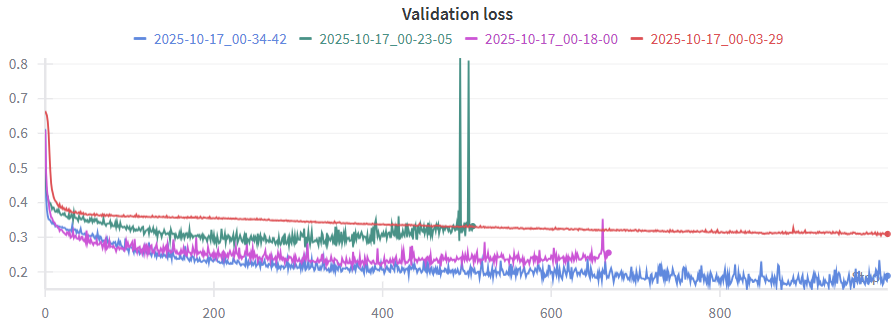